Fourier analysis is a field that studies how a mathematical function can be decomposed into a series of simpler trigonometric functions. The Fourier transform is a tool from this field for decomposing a function into its component frequencies or a tool that allows you to take a signal and see the power of each frequency in it. 

1. A signal is information that changes over time. For example, audio, video, and voltage traces are all examples of signals.
2. A frequency is the speed at which something repeats. For example, clocks tick at a frequency of one hertz (Hz), or one repetition per second.
3. Power, in this case, just means the strength of each frequency.

The following image is a visual demonstration of frequency and power on some sine waves:

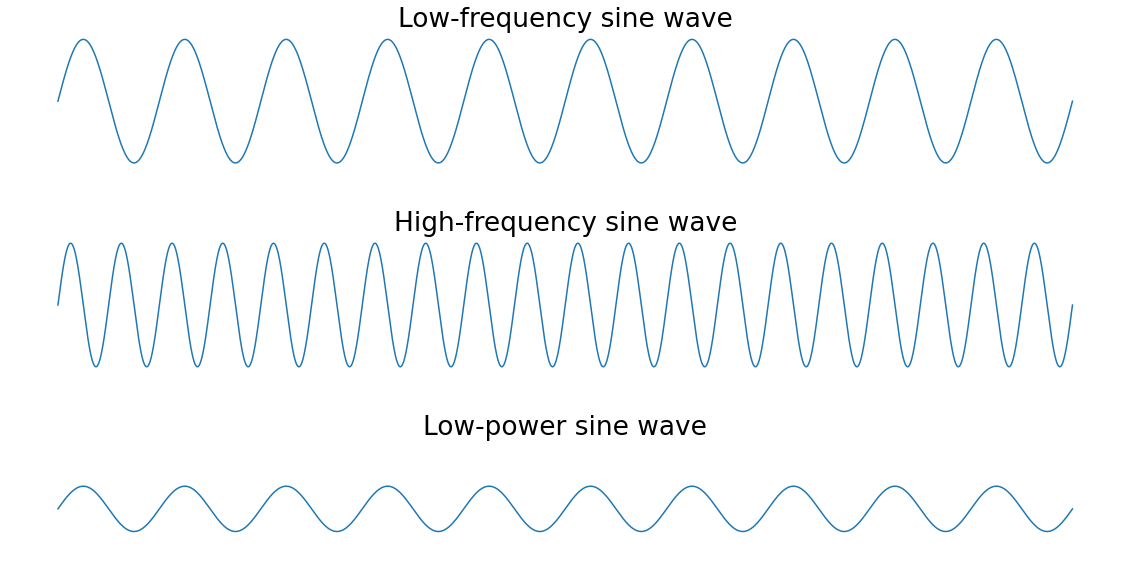

The peaks of the high-frequency sine wave are closer together than those of the low-frequency sine wave since they repeat more frequently. The low-power sine wave has smaller peaks than the other two sine waves.

Why Would You Need the Fourier Transform?

The Fourier transform is useful in many applications. For example, Shazam and other music identification services use the Fourier transform to identify songs. JPEG compression uses a variant of the Fourier transform to remove the high-frequency components of images. Speech recognition uses the Fourier transform and related transforms to recover the spoken words from raw audio.

In general, you need the Fourier transform if you need to look at the frequencies in a signal. If working with a signal in the time domain is difficult, then using the Fourier transform to move it into the frequency domain is worth trying. In the next section, you’ll look at the differences between the time and frequency domains.

Time Domain vs Frequency Domain

Throughout the rest of the tutorial, you’ll see the terms time domain and frequency domain. These two terms refer to two different ways of looking at a signal, either as its component frequencies or as information that varies over time.

In the time domain, a signal is a wave that varies in amplitude (y-axis) over time (x-axis). You’re most likely used to seeing graphs in the time domain, such as this one:

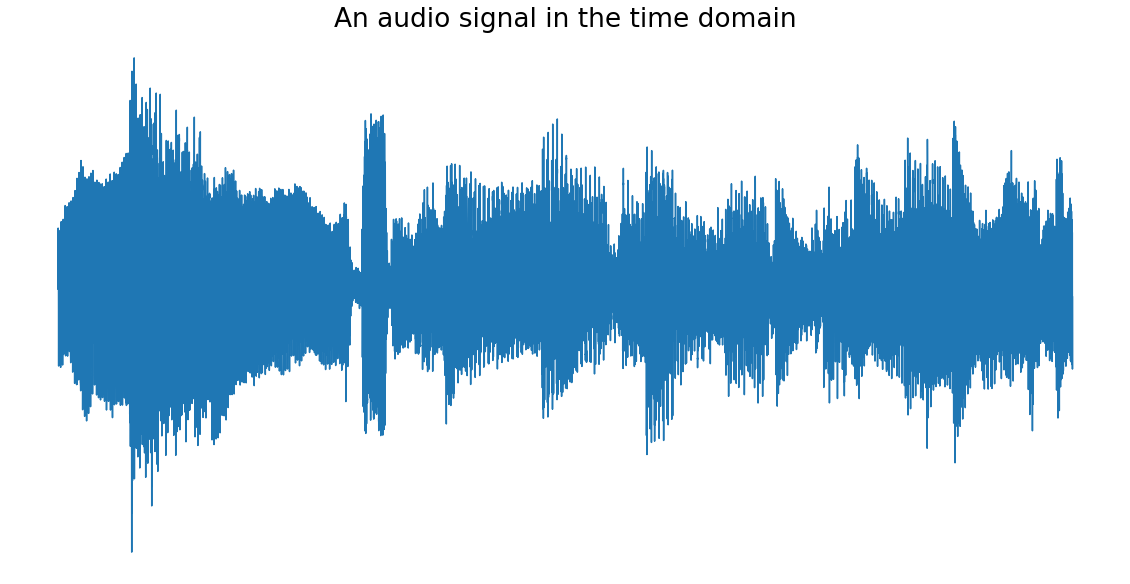

This is an image of some audio, which is a time-domain signal. The horizontal axis represents time, and the vertical axis represents amplitude.

In the frequency domain, a signal is represented as a series of frequencies (x-axis) that each have an associated power (y-axis). The following image is the above audio signal after being Fourier transformed:

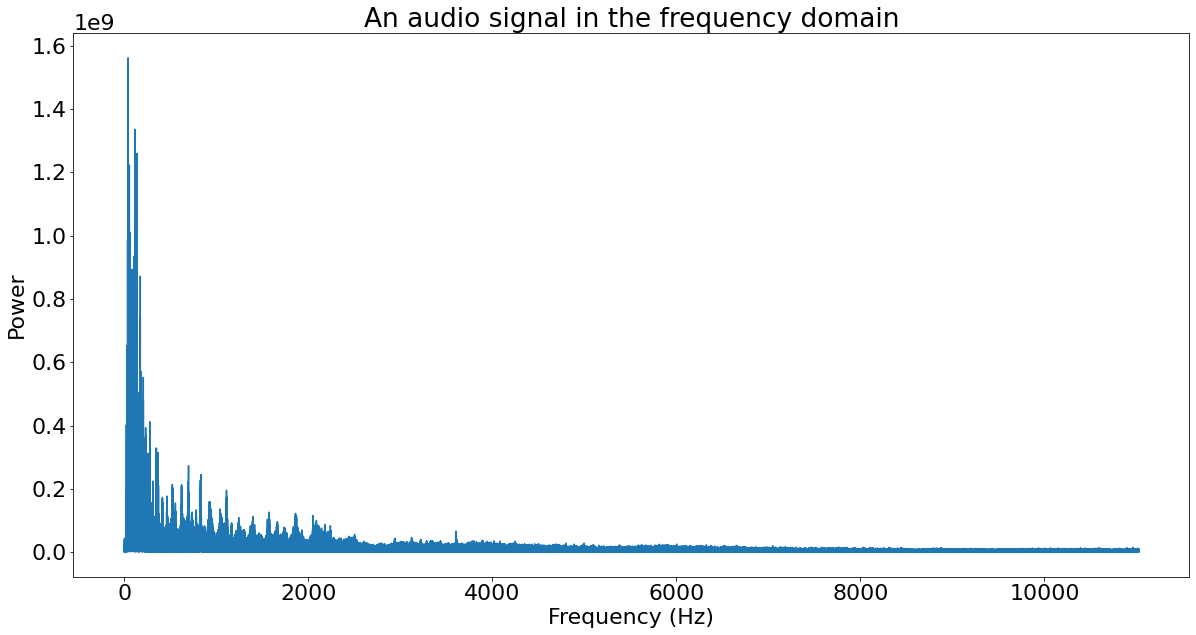

Here, the audio signal from before is represented by its constituent frequencies. Each frequency along the bottom has an associated power, producing the spectrum that you see.

Types of Fourier Transforms

The Fourier transform can be subdivided into different types of transform. The most basic subdivision is based on the kind of data the transform operates on: continuous functions or discrete functions. This tutorial will deal with only the discrete Fourier transform (DFT).

You’ll often see the terms DFT and FFT used interchangeably, even in this tutorial. However, they aren’t quite the same thing. The fast Fourier transform (FFT) is an algorithm for computing the discrete Fourier transform (DFT), whereas the DFT is the transform itself.

Another distinction that you’ll see made in the scipy.fft library is between different types of input. fft() accepts complex-valued input, and rfft() accepts real-valued input. Skip ahead to the section Using the Fast Fourier Transform (FFT) for an explanation of complex and real numbers.

Two other transforms are closely related to the DFT: the discrete cosine transform (DCT) and the discrete sine transform (DST). You’ll learn about those in the section The Discrete Cosine and Sine Transforms.

Practical Example: Remove Unwanted Noise From Signal

To help build your understanding of the Fourier transform and what you can do with it, you’re going to filter some audio. First, you’ll create an audio signal with a high pitched buzz in it, and then you’ll remove the buzz using the Fourier transform.

Creating a Signal

Sine waves are sometimes called pure tones because they represent a single frequency. You’ll use sine waves to generate the audio since they will form distinct peaks in the resulting frequency spectrum.

Another great thing about sine waves is that they’re straightforward to generate using NumPy. If you haven’t used NumPy before, then you can check out What Is NumPy?

Here’s some code that generates a sine wave:

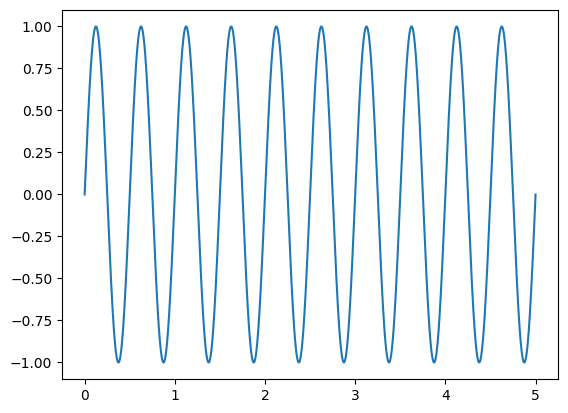

In [15]:
import numpy as np
from matplotlib import pyplot as plt

SAMPLE_RATE = 44100  # Hertz
DURATION = 5  # Seconds

def generate_sine_wave(freq, sample_rate, duration):
    x = np.linspace(0, duration, sample_rate * duration, endpoint=False)
    frequencies = x * freq
    # 2pi because np.sin takes radians
    y = np.sin((2 * np.pi) * frequencies)
    return x, y

# Generate a 2 hertz sine wave that lasts for 5 seconds
x, y = generate_sine_wave(2, SAMPLE_RATE, DURATION)
plt.plot(x, y)
plt.show()

After you import NumPy and Matplotlib, you define two constants:

1. SAMPLE_RATE determines how many data points the signal uses to represent the sine wave per second. So if the signal had a sample rate of 10 Hz and was a five-second sine wave, then it would have 10 * 5 = 50 data points.
2. DURATION is the length of the generated sample.

Next, you define a function to generate a sine wave since you’ll use it multiple times later on. The function takes a frequency, freq, and then returns the x and y values that you’ll use to plot the wave.

The x-coordinates of the sine wave are evenly spaced between 0 and DURATION, so the code uses NumPy’s linspace() to generate them. It takes a start value, an end value, and the number of samples to generate. Setting endpoint=False is important for the Fourier transform to work properly because it assumes a signal is periodic.

np.sin() calculates the values of the sine function at each of the x-coordinates. The result is multiplied by the frequency to make the sine wave oscillate at that frequency, and the product is multiplied by 2π to convert the input values to radians.

Mixing Audio Signals

The good news is that mixing audio signals consists of just two steps:

1. Adding the signals together
2. Normalizing the result

Before you can mix the signals together, you need to generate them:

In [16]:
_, nice_tone = generate_sine_wave(400, SAMPLE_RATE, DURATION)
_, noise_tone = generate_sine_wave(4000, SAMPLE_RATE, DURATION)
noise_tone = noise_tone * 0.3

mixed_tone = nice_tone + noise_tone

There’s nothing new in this code example. It generates a medium-pitch tone and a high-pitch tone assigned to the variables nice_tone and noise_tone, respectively. You’ll use the high-pitch tone as your unwanted noise, so it gets multiplied by 0.3 to reduce its power. The code then adds these tones together. Note that you use the underscore (_) to discard the x values returned by generate_sine_wave().

The next step is normalization, or scaling the signal to fit into the target format. Due to how you’ll store the audio later, your target format is a 16-bit integer, which has a range from -32768 to 32767:

Here, the code scales mixed_tone to make it fit snugly into a 16-bit integer and then cast it to that data type using NumPy’s np.int16. Dividing mixed_tone by its maximum value scales it to between -1 and 1. When this signal is multiplied by 32767, it is scaled between -32767 and 32767, which is roughly the range of np.int16. The code plots only the first 1000 samples so you can see the structure of the signal more clearly.

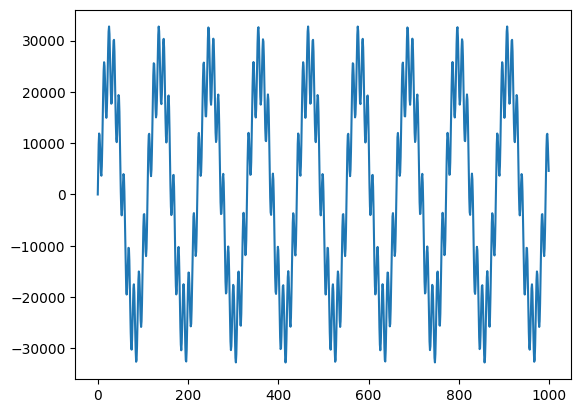

In [17]:
normalized_tone = np.int16((mixed_tone / mixed_tone.max()) * 32767)

plt.plot(normalized_tone[:1000])
plt.show()

The signal looks like a distorted sine wave. The sine wave you see is the 400 Hz tone you generated, and the distortion is the 4000 Hz tone. If you look closely, then you can see the distortion has the shape of a sine wave.

To listen to the audio, you need to store it in a format that an audio player can read. The easiest way to do that is to use SciPy’s wavfile.write method to store it in a WAV file. 16-bit integers are a standard data type for WAV files, so you’ll normalize your signal to 16-bit integers:

In [18]:
import IPython
from scipy.io.wavfile import write

# Remember SAMPLE_RATE = 44100 Hz is our playback rate
write("mysinewave.wav", SAMPLE_RATE, normalized_tone)
IPython.display.Audio("mysinewave.wav")

This code will write to a file mysinewave.wav in the directory where you run your Python script. You can then listen to this file using any audio player or even with Python. You’ll hear a lower tone and a higher-pitch tone. These are the 400 Hz and 4000 Hz sine waves that you mixed.

Once you’ve completed this step, you have your audio sample ready. The next step is removing the high-pitch tone using the Fourier transform!

Using the Fast Fourier Transform (FFT)

It’s time to use the FFT on your generated audio. The FFT is an algorithm that implements the Fourier transform and can calculate a frequency spectrum for a signal in the time domain, like your audio:

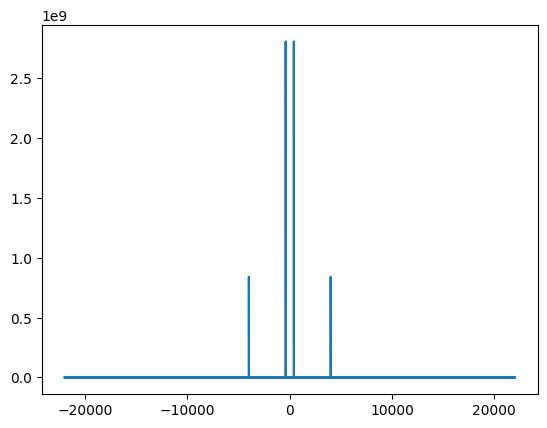

In [19]:
from scipy.fft import fft, fftfreq

# Number of samples in normalized_tone
N = SAMPLE_RATE * DURATION

yf = fft(normalized_tone)
xf = fftfreq(N, 1 / SAMPLE_RATE)

plt.plot(xf, np.abs(yf))
plt.show()

This code will calculate the Fourier transform of your generated audio and plot it. Before breaking it down, take a look at the plot that it produces.

You can see two peaks in the positive frequencies and mirrors of those peaks in the negative frequencies. The positive-frequency peaks are at 400 Hz and 4000 Hz, which corresponds to the frequencies that you put into the audio.

The Fourier transform has taken your complicated, wibbly signal and turned it into just the frequencies it contains. Since you put in only two frequencies, only two frequencies have come out. The negative-positive symmetry is a side effect of putting real-valued input into the Fourier transform, but you’ll hear more about that later.

In the first couple of lines, you import the functions from scipy.fft that you’ll use later and define a variable, N, that stores the total number of samples in the signal.

After this comes the most important section, calculating the Fourier transform:

1. fft() calculates the transform itself.
2. fftfreq() calculates the frequencies in the center of each bin in the output of fft(). Without this, there would be no way to plot the x-axis on your frequency spectrum.

A bin is a range of values that have been grouped, like in a histogram. For more information on bins, see this Signal Processing Stack Exchange question. For the purposes of this tutorial, you can think of them as just single values.

Once you have the resulting values from the Fourier transform and their corresponding frequencies, you can plot them.

The interesting part of this code is the processing you do to yf before plotting it. You call np.abs() on yf because its values are complex.

A complex number is a number that has two parts, a real part and an imaginary part. There are many reasons why it’s useful to define numbers like this, but all you need to know right now is that they exist.

Mathematicians generally write complex numbers in the form a + bi, where a is the real part and b is the imaginary part. The i after b means that b is an imaginary number.

Since complex numbers have two parts, graphing them against frequency on a two-dimensional axis requires you to calculate a single value from them. This is where np.abs() comes in. It calculates √(a² + b²) for complex numbers, which is an overall magnitude for the two numbers together and importantly a single value.

Making It Faster With rfft()

The frequency spectrum that fft() outputted was reflected about the y-axis so that the negative half was a mirror of the positive half. This symmetry was caused by inputting real numbers (not complex numbers) to the transform.

You can use this symmetry to make your Fourier transform faster by computing only half of it. scipy.fft implements this speed hack in the form of rfft().

The great thing about rfft() is that it’s a drop-in replacement for fft().

Swapping in rfft(), the code remains mostly the same, just with a couple of key changes:

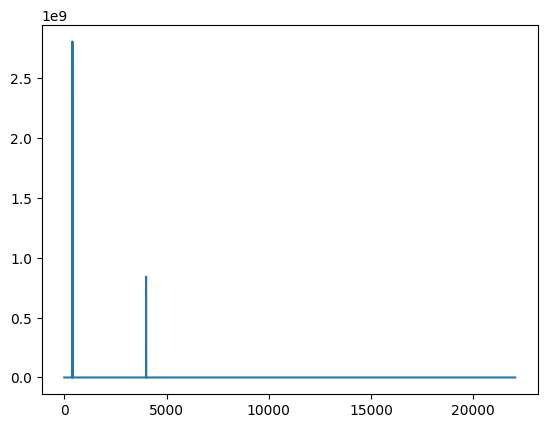

In [20]:
from scipy.fft import rfft, rfftfreq

# Note the extra 'r' at the front
yf = rfft(normalized_tone)
xf = rfftfreq(N, 1 / SAMPLE_RATE)

plt.plot(xf, np.abs(yf))
plt.show()

Since rfft() returns only half the output that fft() does, it uses a different function to get the frequency mapping, rfftfreq() instead of fftfreq().

rfft() still produces complex output, so the code to plot its result remains the same. The plot, however, should look like the following since the negative frequencies will have disappeared.

You can see that the image above is just the positive side of the frequency spectrum that fft() produces. rfft() never calculates the negative half of the frequency spectrum, which makes it faster than using fft().

Using rfft() can be up to twice as fast as using fft(), but some input lengths are faster than others. If you know you’ll be working only with real numbers, then it’s a speed hack worth knowing.

Now that you have the frequency spectrum of the signal, you can move on to filtering it.

Filtering the Signal

One great thing about the Fourier transform is that it’s reversible, so any changes you make to the signal in the frequency domain will apply when you transform it back to the time domain. You’ll take advantage of this to filter your audio and get rid of the high-pitched frequency.

The values returned by rfft() represent the power of each frequency bin. If you set the power of a given bin to zero, then the frequencies in that bin will no longer be present in the resulting time-domain signal.

Using the length of xf, the maximum frequency, and the fact that the frequency bins are evenly spaced, you can work out the target frequency’s index:

In [21]:
# The maximum frequency is half the sample rate
points_per_freq = len(xf) / (SAMPLE_RATE / 2)

# Our target frequency is 4000 Hz
target_idx = int(points_per_freq * 4000)

You can then set yf to 0 at indices around the target frequency to get rid of it:

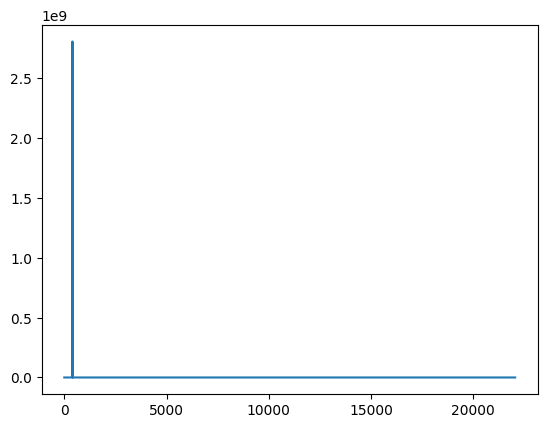

In [22]:
yf[target_idx - 1 : target_idx + 2] = 0

plt.plot(xf, np.abs(yf))
plt.show()

Since there’s only one peak, it looks like it worked! Next, you’ll apply the inverse Fourier transform to get back to the time domain.

Applying the Inverse FFT

Applying the inverse FFT is similar to applying the FFT:

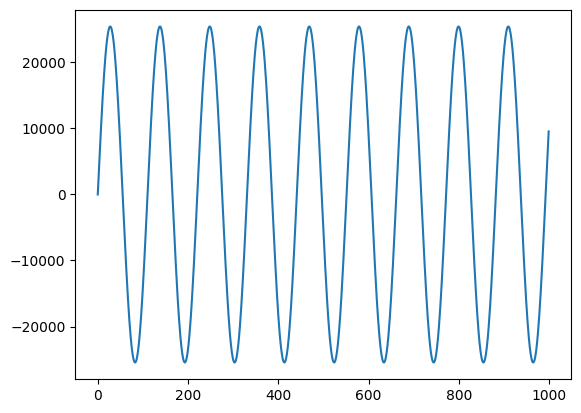

In [23]:
from scipy.fft import irfft

new_sig = irfft(yf)

plt.plot(new_sig[:1000])
plt.show()

Since you are using rfft(), you need to use irfft() to apply the inverse. However, if you had used fft(), then the inverse function would have been ifft().

As you can see, you now have a single sine wave oscillating at 400 Hz, and you’ve successfully removed the 4000 Hz noise.

Once again, you need to normalize the signal before writing it to a file. You can do it the same way as last time:

In [24]:
import IPython
from scipy.io.wavfile import write

norm_new_sig = np.int16(new_sig * (32767 / new_sig.max()))

# Remember SAMPLE_RATE = 44100 Hz is our playback rate
write("clean.wav", SAMPLE_RATE, norm_new_sig)
IPython.display.Audio("clean.wav")

Avoiding Filtering Pitfalls

The above example is more for educational purposes than real-world use. Replicating the process on a real-world signal, such as a piece of music, could introduce more buzz than it removes.

In the real world, you should filter signals using the filter design functions in the scipy.signal package. Filtering is a complex topic that involves a lot of math. For a good introduction, take a look at The Scientist and Engineer’s Guide to Digital Signal Processing

Conclusion

The Fourier transform is a powerful concept that’s used in a variety of fields, from pure math to audio engineering and even finance. You’re now familiar with the discrete Fourier transform and are well equipped to apply it to filtering problems using the scipy.fft module.